In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 791 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bikes', 'Cars']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0]


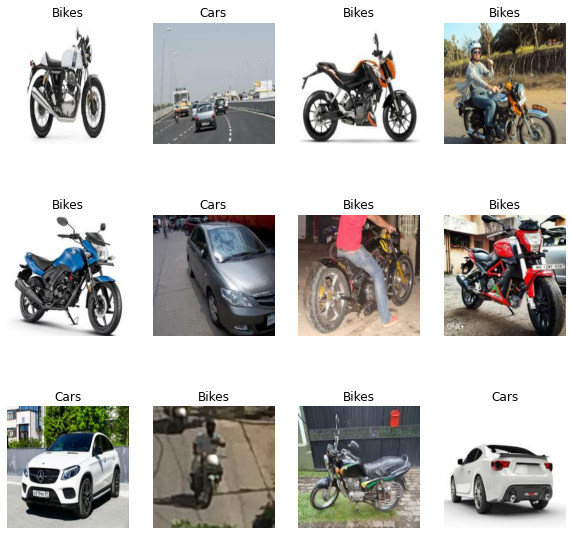

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

50

In [8]:
train_size = 0.8
len(dataset)*train_size

40.0

In [9]:
train_ds = dataset.take(40)
len(train_ds)

40

In [10]:
test_ds = dataset.skip(40)
len(test_ds)

10

In [11]:
val_size=0.1
len(dataset)*val_size

5.0

In [12]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [13]:
test_ds = test_ds.skip(2)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

40

In [17]:
len(val_ds)

5

In [18]:
len(test_ds)

5

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
40/40 [==============================] - 103s 2s/step - loss: 0.6534 - accuracy: 0.6422 - val_loss: 0.5421 - val_accuracy: 0.7183
Epoch 2/20
40/40 [==============================] - 86s 2s/step - loss: 0.5131 - accuracy: 0.7672 - val_loss: 0.4083 - val_accuracy: 0.8169
Epoch 3/20
40/40 [==============================] - 77s 2s/step - loss: 0.4336 - accuracy: 0.8203 - val_loss: 0.3611 - val_accuracy: 0.7746
Epoch 4/20
40/40 [==============================] - 79s 2s/step - loss: 0.3827 - accuracy: 0.8500 - val_loss: 0.4350 - val_accuracy: 0.8169
Epoch 5/20
40/40 [==============================] - 66s 2s/step - loss: 0.3356 - accuracy: 0.8687 - val_loss: 0.5446 - val_accuracy: 0.7746
Epoch 6/20
40/40 [==============================] - 66s 2s/step - loss: 0.3149 - accuracy: 0.8859 - val_loss: 0.5054 - val_accuracy: 0.7746
Epoch 7/20
40/40 [==============================] - 69s 2s/step - loss: 0.2958 - accuracy: 0.8922 - val_loss: 0.6849 - val_accuracy: 0.7465
Epoch 8/20
40/40 [=

In [26]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 4s 393ms/step - loss: 0.7262 - accuracy: 0.7875


In [27]:
scores

[0.7262041568756104, 0.7875000238418579]